# Assigment A01 - Predict price of diamond ring

A professor of machine learning is planning to get married to his long-time girlfriend. He has never  shopped for diamonds before. In the mall, he was confronted with a dizzying array of diamond  characteristics, configurations, and pricing. His quick search revealed that diamonds are primarily  characterized by 4C viz. Color, Cut, Carat Weight and Clarity besides Polish, Symmetry, and certification. 
He scrapped the web to collect information from three different wholesaler websites to build his pricing model to ensure he does not get cheated while purchasing the diamond ring. 
## Goal and Metrics
The goal is to predict the price of the diamond ring of his interest.
Metrics 

In [148]:
#import required packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib.cbook import boxplot_stats
from sklearn.metrics import mean_squared_error, r2_score
from math import ceil, log
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [149]:
def evaluation_metric(predicted, actual):
    rmse = mean_squared_error(actual, predicted, squared=False)
    rsquared = r2_score(actual, predicted)
    return rmse, rsquared



## Exploration
In diamond, the quality is determined by Cut, Color, Clarity and Carat [https://www.diamonds.pro/education/4cs-diamonds/]. The price of diamond is determinant on Certification and Quality(4Cs). 
Therefore this section will review each features of the data and interpret the discoveries. 
The data has no missing values

In [150]:
data = pd.read_excel("MBA6636_SM21_Professor_Proposes_Data.xlsx", sheet_name="Data")
data.describe()

,Carat,Price,Wholesaler
count,440.00000,440.000000,440.000000
mean,0.66925,1716.738636,2.318182
std,0.37980,1175.689127,0.700560
min,0.09000,160.000000,1.000000
25%,0.30000,520.000000,2.000000
50%,0.81000,2169.000000,2.000000
75%,1.01000,3012.500000,3.000000
max,1.58000,3145.000000,3.000000


In [151]:
data.isnull().sum()

Carat            0
Colour           0
Clarity          0
Cut              0
Certification    0
Polish           0
Symmetry         0
Price            0
Wholesaler       0
dtype: int64

### Ordinal Features
Reviewing the data, features Cut, Polish and Symmetry are ordinal data. 
They are ranked from excellent to poor. The ordinal features will be mapped to numerical values that corresponds to the weight of the value

34%, 14%, 12% of the diamond `Cut`, `Polish` and `Symmetry` respectively are excellent. 
Using a data balance of 10% for each category, It can be said that feature cut is balanced as all category have at least 10% of the dataset. Polish has 1.1% of `Ideal` and `Fair`, while Symmetry has 1.1% of `ideal` and 2.8% `fair`. Thus, the imbalanced category of `Ideal` and `Fair` in features `Cut` and `Symmetr`y will be added to `Good` (using the ordinal weight assigned to each value, Good is the average of Ideal and Fair).

In [152]:
''' 
    Ordinal Ranking Meaning

    X	Excellent
    V	Very Good
    I	Ideal
    G	Good
    F	Fair

'''
ordinal_features = ['Cut', 'Polish', 'Symmetry']
ordinal_ranking  = {'X': 5, 'V': 4, 'I':3, 'G':2, 'F':1 }

In [153]:
data.shape[0]

440

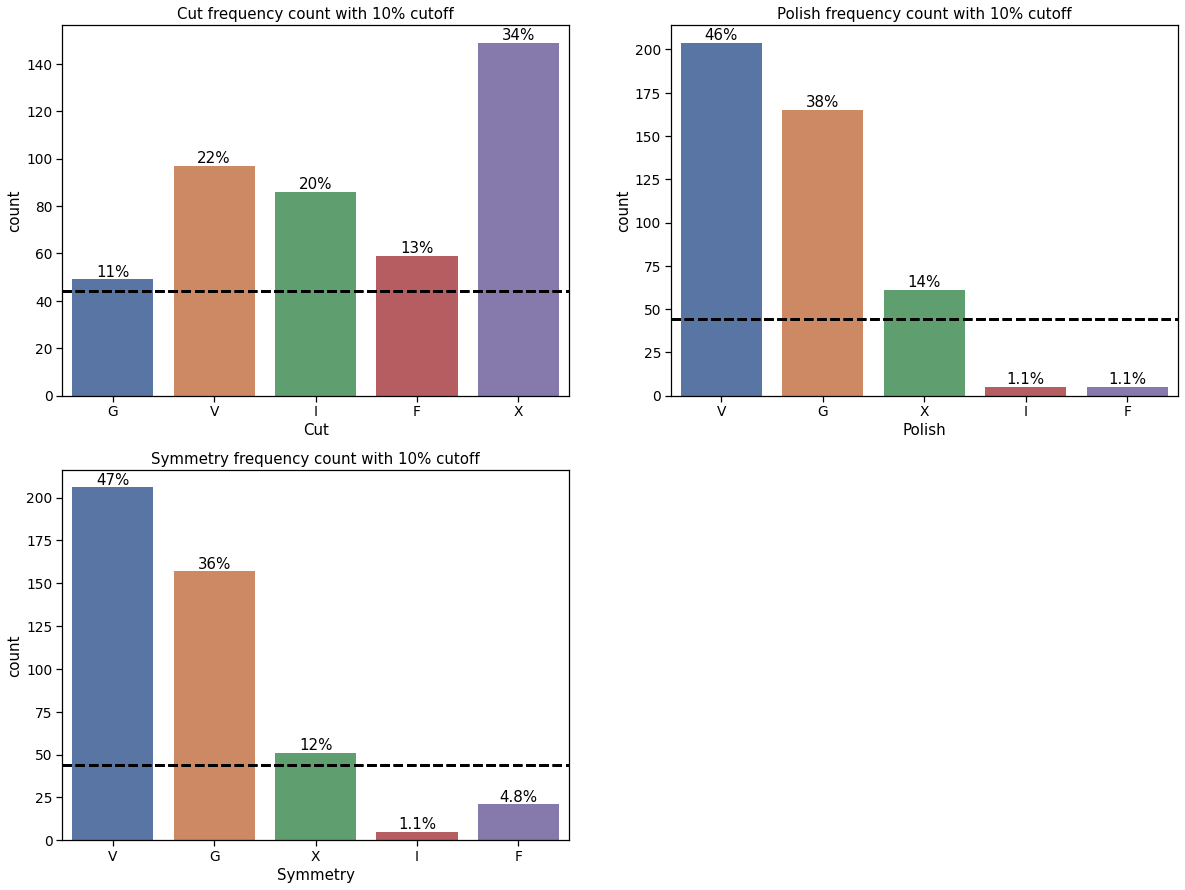

In [154]:
n_cols = 2
n_rows = ceil(len(ordinal_features)/n_cols)
counter = 1
percent_10 = data.shape[0] * 0.10

fig = plt.figure(figsize=(20,15))
for col in ordinal_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('{} frequency count with 10% cutoff'.format(col))
    plt.xlabel(col)
    g = sns.countplot(data[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(data[col])), (x.mean(), y), ha='center', va='bottom')
        g.axhline(percent_10, color='black',
            ls='--', 
            lw=2.5)
    counter += 1

plt.show();

Ideal and Fair category are replaced with Good in Symmentry and Polish features. The new distribution (shown below) is balanced

In [155]:
data['Polish'] = data['Polish'].replace(['I', 'F'], 'G')
data['Symmetry'] = data['Symmetry'].replace(['I', 'F'], 'G')

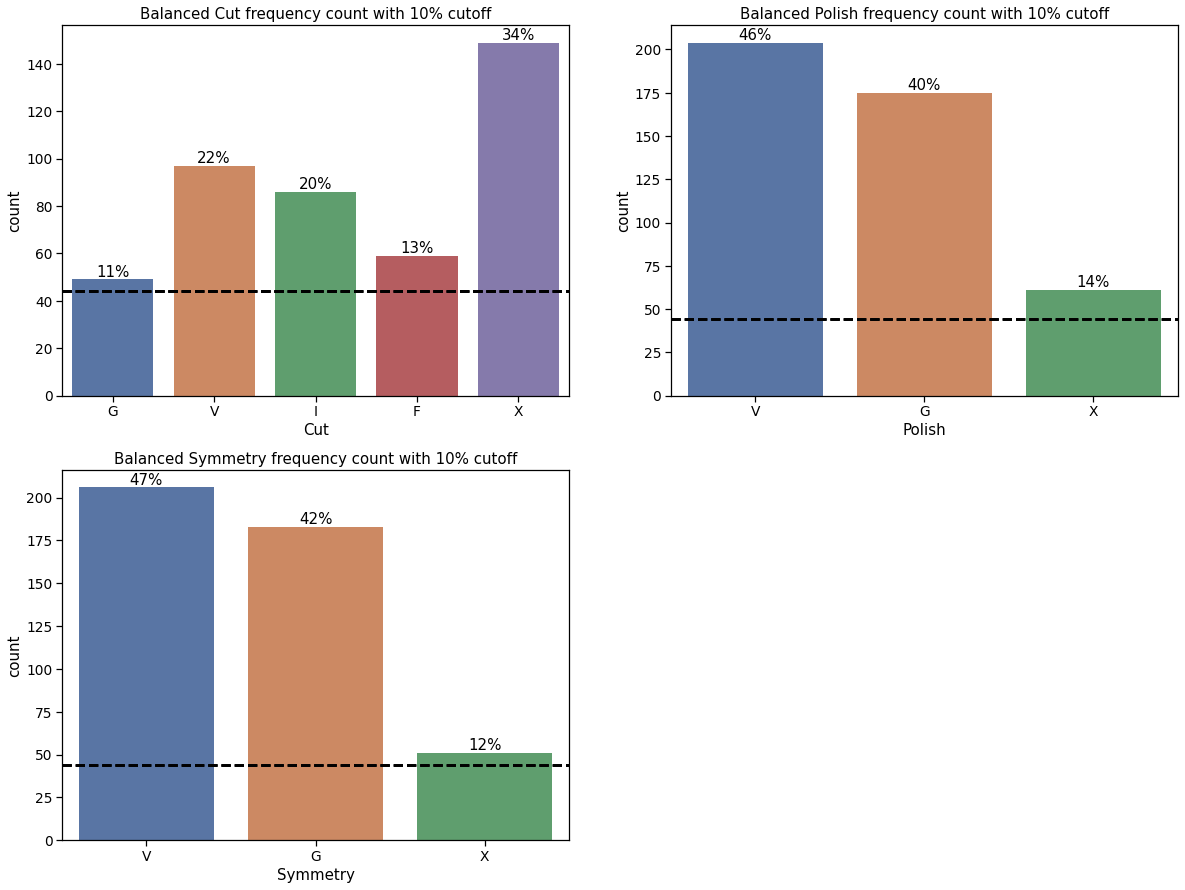

In [156]:
n_cols = 2
n_rows = ceil(len(ordinal_features)/n_cols)
counter = 1
percent_10 = data.shape[0] * 0.10
fig = plt.figure(figsize=(20,15))
for col in ordinal_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('Balanced {} frequency count with 10% cutoff'.format(col))
    plt.xlabel(col)
    g = sns.countplot(data[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(data[col])), (x.mean(), y), ha='center', va='bottom')
        g.axhline(percent_10, color='black',
            ls='--', 
            lw=2.5)
    counter += 1

plt.show();

In [157]:
for col in ordinal_features:
    data[col] = data[col].map(ordinal_ranking)

### Categorical Features
Features Colour, Clarity and Certification fall into bucket data. 
From the description of Colours, some colors mean the same, thus they will be labelled together to reduce the sensitivity of the feature. For example, D-F are colorless diamonds.

using 10% cutoff, it is seen that in feature Color, `very light yellow` accounts for 2.4% of the data which is below the cutoff. since `very light yellow` is a type of yellow, the data in `very light yellow` and `faint yellow` will be relabbeled as `yellow`

In certification feature, `GIA` and `EGL` comprise of 87% of the data. The other categories `AGS`, `DOW` and `IGI` will be labeled as others

For Clarity, the new category is itemized below

|  Clarity Code | Clarity  | New Category  | New code |
|---|---|---|---|
|  I1 | very few inclusions visible to naked eye  |visible to naked eyes   | I |
| I2  | few inclusions visible to naked eye  | visible to naked eyes  | I |
|  SI1 | very very few inclusions at 10X  | inclusions at 10X  | SI |
|  SI2 | very few inclusions at 10X  | inclusions at 10X  | SI |
|  SI3 | several inclusions at 10X  | inclusions at 10X  | SI |
|  VS1 | few inclusions at 30X  | inclusions at  30X  | VS |
|  VS2 | 	several inclusions at 30X  | inclusions at  30X  |  VS |
|  VVS1 | 	very very few inclusions at 30X  | inclusions at  30X  |  VS |
|  VVS2 | 	very few inclusions at 30X  | inclusions at  30X  |  VS |




In [158]:
colors_map = {'D':'colorless', 'E':'colorless', 'F':'colorless', 'G':'near colorless', 'H':'near colorless', 'I':'near colorless',
              'J':'faint yellow', 'K':'faint yellow', 'L':'very light yellow', 'M':'very light yellow', 'N':'very light yellow',
              'O':'light yellow'}
data.Colour =  data.Colour.map(colors_map)

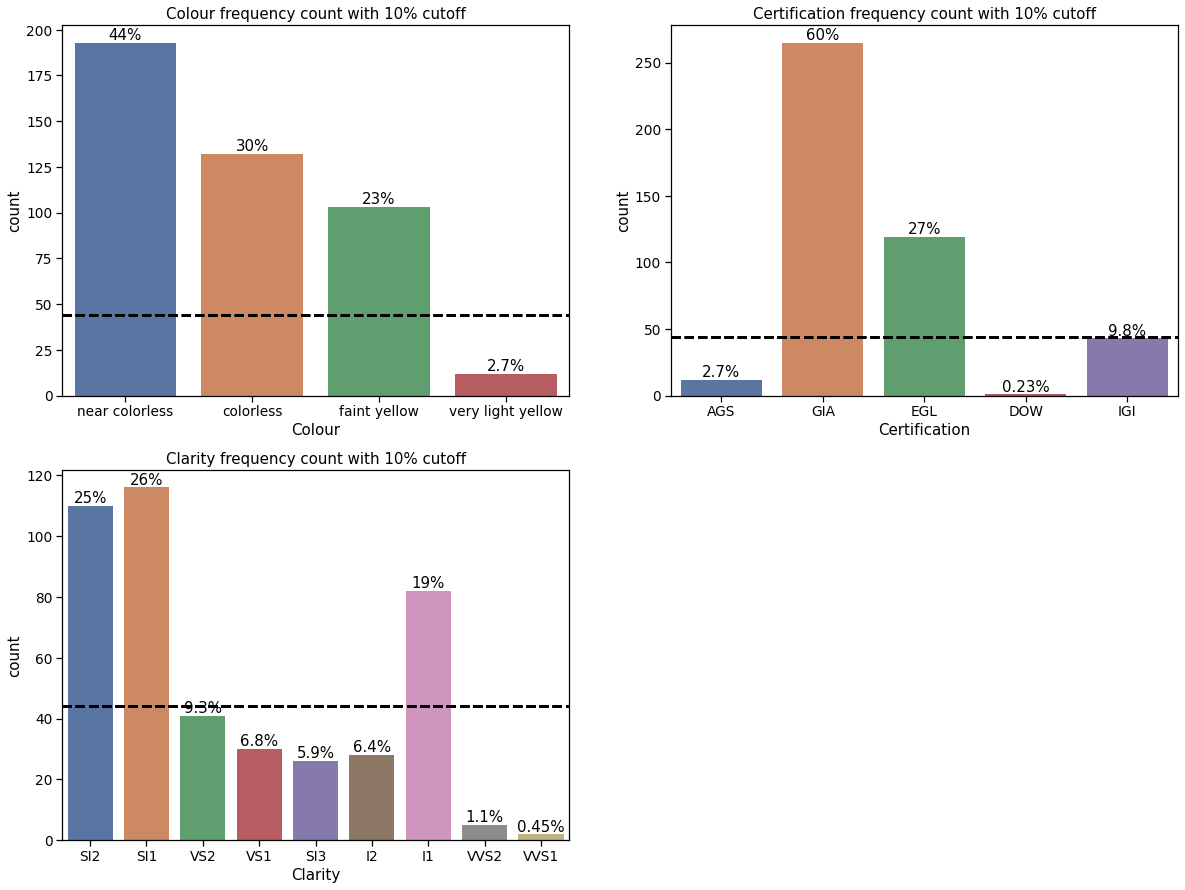

In [159]:
categorical_features = ['Colour', 'Certification', 'Clarity']

n_cols = 2
n_rows = ceil(len(categorical_features)/n_cols)
counter = 1
percent_10 = data.shape[0] * 0.10

fig = plt.figure(figsize=(20,15))
for col in categorical_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('{} frequency count with 10% cutoff'.format(col))
    plt.xlabel(col)
    g = sns.countplot(data[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(data[col])), (x.mean(), y), ha='center', va='bottom')
        g.axhline(percent_10, color='black',
            ls='--', 
            lw=2.5)
    counter += 1

plt.show();

In [160]:
data['Colour'] = data['Colour'].replace(['very light yellow', 'faint yellow'], 'yellow')
data.Certification = data.Certification.replace(['AGS', 'DOW', 'IGI'], 'others')
data.Clarity = data.Clarity.replace(['I1', 'I2'], 'I')
data.Clarity = data.Clarity.replace(['SI1', 'SI2', 'SI3'], 'SI')
data.Clarity = data.Clarity.replace(['VS1', 'VS2', 'VVS1', 'VVS2'], 'VS')

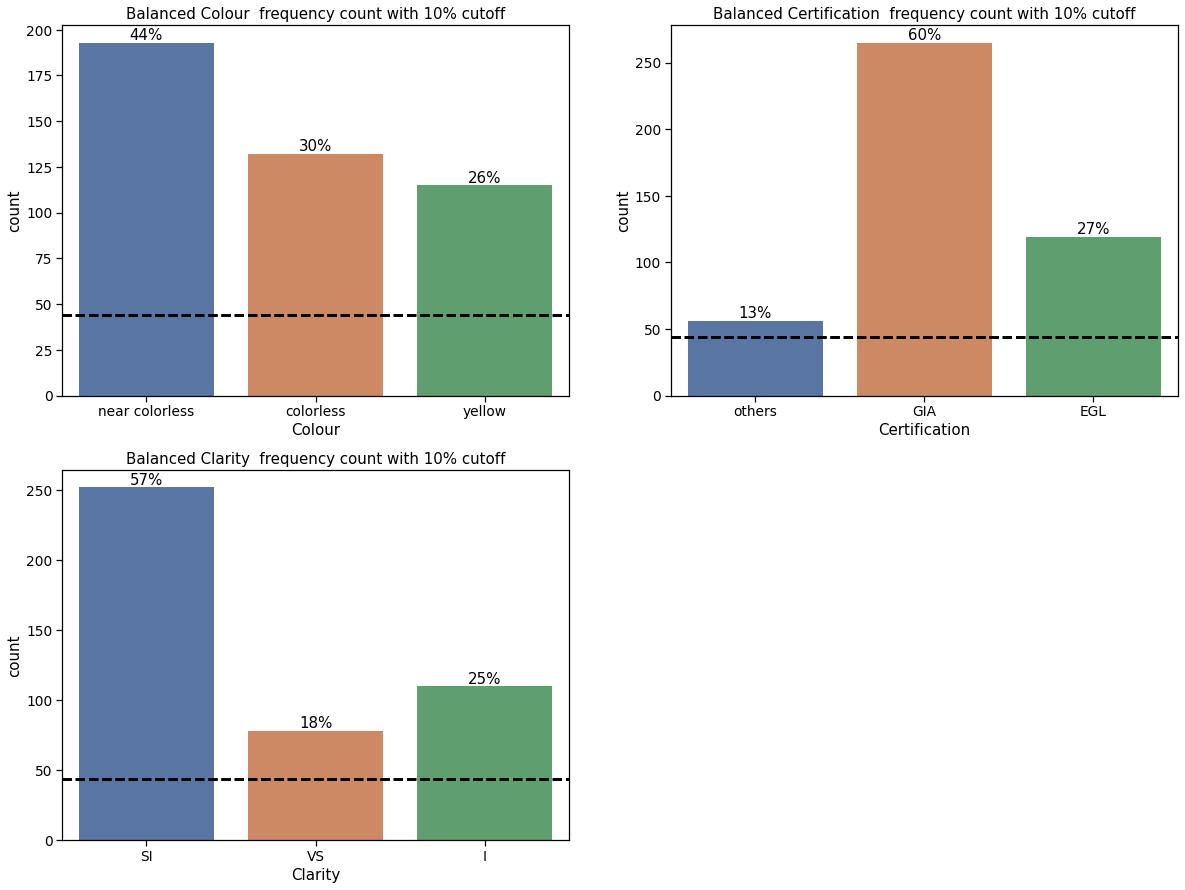

In [161]:
n_cols = 2
n_rows = ceil(len(categorical_features)/n_cols)
counter = 1
percent_10 = data.shape[0] * 0.10

fig = plt.figure(figsize=(20,15))
for col in categorical_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('Balanced {}  frequency count with 10% cutoff'.format(col))
    plt.xlabel(col)
    g = sns.countplot(data[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(data[col])), (x.mean(), y), ha='center', va='bottom')
        g.axhline(percent_10, color='black',
            ls='--', 
            lw=2.5)
    counter += 1

plt.show();

In [162]:
data.head()

,Carat,Colour,Clarity,Cut,Certification,Polish,Symmetry,Price,Wholesaler
0,0.92,near colorless,SI,2,others,4,4,3000,1
1,0.92,near colorless,SI,4,others,2,2,3000,1
2,0.82,colorless,SI,3,GIA,5,5,3004,1
3,0.81,near colorless,SI,3,GIA,5,4,3004,1
4,0.90,yellow,VS,4,GIA,4,4,3006,1


#### Data Encoding

Since modeling can be performed on numeric data, `pandas get_dummies` allows for conversion of categorical variable to indicator variables. In other to reduce colinearity, the first indicator will be dropped `K-1`


In [163]:
data = pd.get_dummies(data, drop_first=True)

### Carat

The carat distribution is bi-modal. It has two peaks at around `0.3` and `1.02`. `O.3` has the highest peak
The mean of the distribution is `0.66925`, median is `0.81`, skewness of `-0.05` and kutosis of `-1.67`

The distribution can be said to be heavy at the peak (kurtosis of -1.67), bi-modal and fairly symmetric (skewness). There are no outliers in the data


In [164]:
data['Carat'].describe()

count    440.00000
mean       0.66925
std        0.37980
min        0.09000
25%        0.30000
50%        0.81000
75%        1.01000
max        1.58000
Name: Carat, dtype: float64

In [165]:
data.Carat.skew()

-0.05005001299750907

In [166]:
data.Carat.kurtosis()

-1.6659568124452417

In [167]:
data.Carat.mode()

0    0.3
Name: Carat, dtype: float64

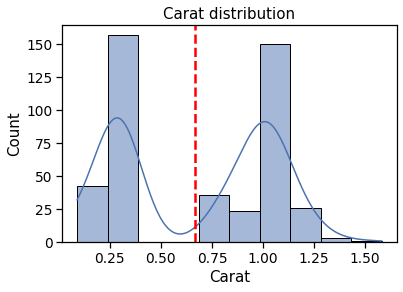

In [168]:
sns.histplot(data=data, x = "Carat", kde=True);
plt.title("Carat distribution")
plt.axvline(x=data.Carat.mean(),
            color='red',
            ls='--', 
            lw=2.5);

[]


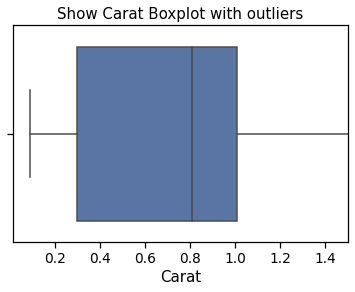

In [169]:
ax = sns.boxplot(data['Carat'])
outliers = [y for stat in boxplot_stats(data['Carat']) for y in stat['fliers']]
print(outliers)
for y in outliers:
    ax.plot(1, y, 'p')
ax.set_xlim(right=1.5)
plt.title("Show Carat Boxplot with outliers")
plt.show()

### Price

The price distribution as with carat is bi-modal

In [170]:
data['Price'].describe()

count     440.000000
mean     1716.738636
std      1175.689127
min       160.000000
25%       520.000000
50%      2169.000000
75%      3012.500000
max      3145.000000
Name: Price, dtype: float64

In [171]:
data.Price.skew()

-0.05199270337099618

In [172]:
data.Price.kurtosis()

-1.8299160478092316

In [173]:
data.Price.mode()

0    520
Name: Price, dtype: int64

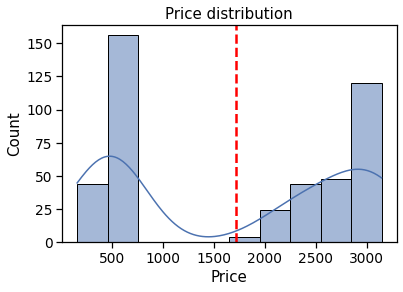

In [174]:
sns.histplot(data=data, x = "Price", kde=True);
plt.title("Price distribution")
plt.axvline(x=data.Price.mean(),
            color='red',
            ls='--', 
            lw=2.5);

[]


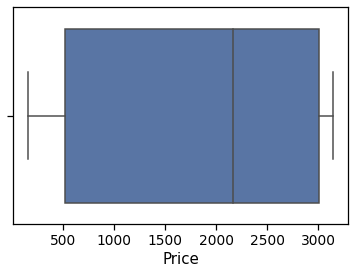

In [175]:
sns.boxplot(data['Price'])
outliers = [y for stat in boxplot_stats(data['Price']) for y in stat['fliers']]
print(outliers)


## Correlation
correlation matrix is computed for all features. From the result of correlation, `wholeseller` has a high correlation with `price` and `carat` and thus will be dropped.

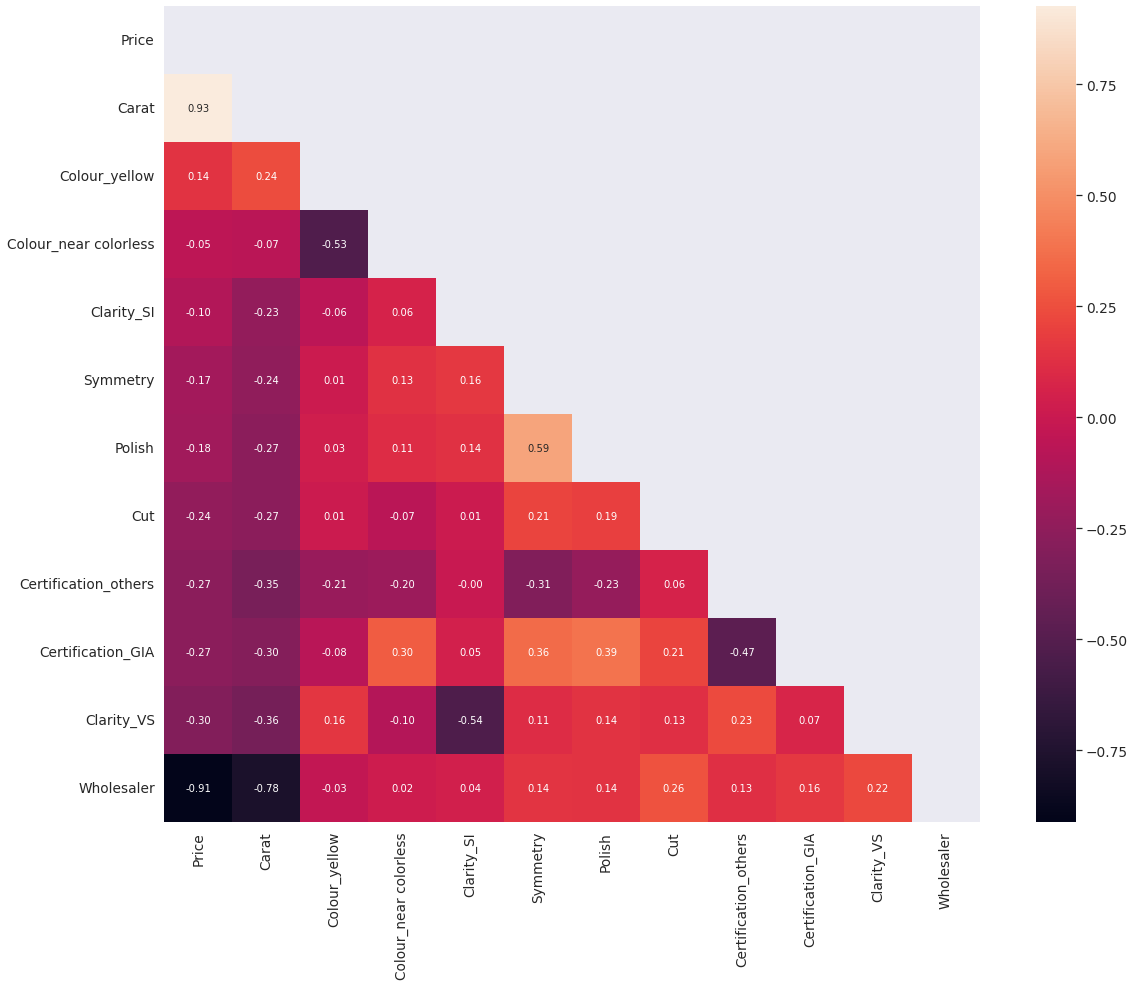

In [176]:
corr_matrix = data.corr()
corr_cols = corr_matrix.nlargest(12, 'Price')['Price'].index
cm = np.corrcoef(data[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(20,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

### Scaling
For modelling to be effective, the data will be scaled, so that eash feature has the same weight. 

In [177]:
target = data['Price']
features = data.drop(columns=['Price', 'Wholesaler'])

In [178]:
scalar = StandardScaler()
scalar.fit(features)
features = scalar.transform(features)

## Regression

### OLS

##